# Show that a linear output with BCEWithLogitsLoss function gives the same results as a sigmoid output with BCELoss.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

Generate data

In [ ]:
def XOR_data(D, N, N1):
    N2 = N - N1
    N11 = int(N1/2)
    N12 = N1 - N11
    N21 = int(N2/2)
    N22 = N2 - N21

    spread = 1.0    # Overlap parameter

    x = 2*np.random.rand(N, D)-1
    x[0:N11,:] += np.outer(np.ones(N11),np.array([1,1])*spread)
    x[N11:N1,:] += np.outer(np.ones(N12),np.array([-1,-1])*spread)
    x[N1:N1+N21,:] += np.outer(np.ones(N21),np.array([-1,1])*spread)
    x[N1+N21:N,:] += np.outer(np.ones(N22),np.array([1,-1])*spread)
    y = np.zeros(N)
    y[0:N1] = np.ones(N1)
    y[N1:N] = np.zeros(N2)
    xy = np.concatenate((x,
         np.concatenate((np.array([y]), np.array([np.arange(0,N)]))).T), axis=1)
    return xy

Training and test data

In [ ]:
D = 2   # Number of input feature dimensions
N = 2000 # Size of training and test sets
N1 = int(N/2)
train_data = XOR_data(D, N, N1)

Scatter plot of input data

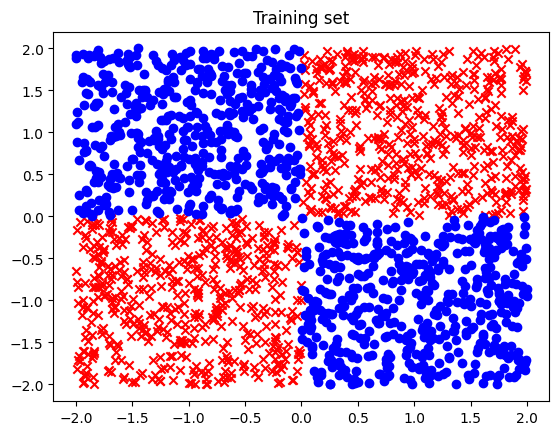

In [ ]:
plt.figure()
plt.scatter(train_data[0:N1,0],train_data[0:N1,1], color = "red", marker = "x")
plt.scatter(train_data[N1:N,0],train_data[N1:N,1], color = "blue", marker = "o")
plt.title("Training set")
#plt.savefig("XOR_training_set.pdf")
plt.show()

Random shuffle of the training set

In [ ]:
train_data = np.random.permutation(train_data)
train_data = torch.from_numpy(train_data)   # Converting numpy tensor to pytorch tensor
train_data = train_data.float() # Converting and processing only with floats

PyTorch models (BCELogits and BCE + Sigmoid)

In [ ]:
class XOR_BCELogits(nn.Module):
    def __init__(self):
        super().__init__()

        # First fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Tanh()
        )

        # Second fully connected layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=5, out_features=2),
            nn.Tanh()
        )

        # Note linear output layer. Examine the loss function (BCEWithLogitsLoss)
        self.fc3 = nn.Linear(in_features=2, out_features=1)


    def forward(self, x):
        z = self.fc1(x)
        z = self.fc2(z)
        z = self.fc3(z)
        z = torch.squeeze(z)    # Very important. Mismatched dimensions otherwise
        return z

Code to save intermediate layer outputs

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

Code to define GPU device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cpu


Free parameters

In [ ]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
batches = int(N/batch_size)

The model

In [ ]:
model_BCE_Logits = XOR_BCELogits()
model_BCE_Logits = model_BCE_Logits.float()
model_BCE_Logits.to(device)
model_BCE_Logits.fc2.register_forward_hook(get_activation('fc2'))

In [ ]:
train_data = train_data.to(device)

In [ ]:
test_data = XOR_data(D, N, N1)
test_data = torch.from_numpy(test_data)
test_data = test_data.float()
test_data = test_data.to(device)

Error and Adam

In [ ]:
error = nn.BCEWithLogitsLoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model_BCE_Logits.parameters(), lr=learning_rate)
print(model_BCE_Logits)

XOR_BCELogits(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=5, out_features=2, bias=True)
    (1): Tanh()
  )
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)


Begin training

In [ ]:
loss_hist = np.zeros(num_epochs)
accuracy_hist = np.zeros(num_epochs)
accuracy_test_hist = np.zeros(num_epochs)

Epoch: 0, Loss: 14.5904369, Training Accuracy: 0.500, Testing Accuracy: 0.500
Epoch: 10, Loss: 2.0599327, Training Accuracy: 0.988, Testing Accuracy: 0.988
Epoch: 20, Loss: 1.0783901, Training Accuracy: 0.993, Testing Accuracy: 0.986
Epoch: 30, Loss: 0.7880560, Training Accuracy: 0.995, Testing Accuracy: 0.988
Epoch: 40, Loss: 0.6373672, Training Accuracy: 0.996, Testing Accuracy: 0.990
Epoch: 50, Loss: 0.5425965, Training Accuracy: 0.997, Testing Accuracy: 0.991
Epoch: 60, Loss: 0.4758898, Training Accuracy: 0.998, Testing Accuracy: 0.991
Epoch: 70, Loss: 0.4254194, Training Accuracy: 0.998, Testing Accuracy: 0.992
Epoch: 80, Loss: 0.3853450, Training Accuracy: 0.998, Testing Accuracy: 0.993
Epoch: 90, Loss: 0.3523582, Training Accuracy: 0.998, Testing Accuracy: 0.993


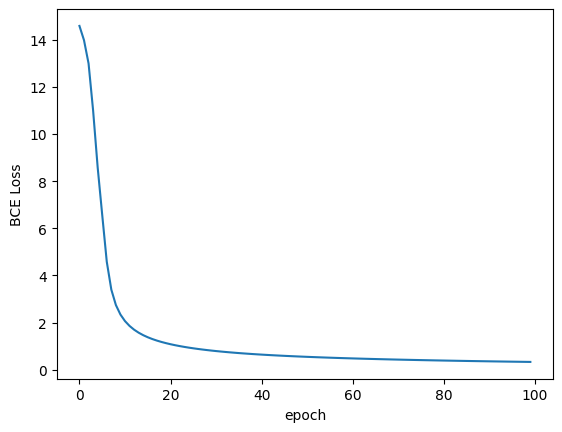

In [ ]:
for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size,0:D]
        labels = train_data[index*batch_size:(index+1)*batch_size,D]

        # Forward pass
        outputs = model_BCE_Logits(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        loss_hist[epoch] += loss.data
        is_correct = torch.round(torch.sigmoid(outputs)) == labels
        accuracy_hist[epoch] += is_correct.sum()/N

    for index in range(batches):
        patterns = test_data[index*batch_size:(index+1)*batch_size,0:D]
        labels = test_data[index*batch_size:(index+1)*batch_size,D]
        outputs = model_BCE_Logits(patterns)
        is_correct = torch.round(torch.sigmoid(outputs)) == labels
        accuracy_test_hist[epoch] += is_correct.sum()/N

    if (epoch % 10 == 0):
      print("Epoch: {}, Loss: {:.7f}, Training Accuracy: {:.3f}, Testing Accuracy: {:.3f}".format(
                        epoch, loss_hist[epoch], accuracy_hist[epoch], accuracy_test_hist[epoch]))

# Plots
plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("BCE Loss")
plt.show()

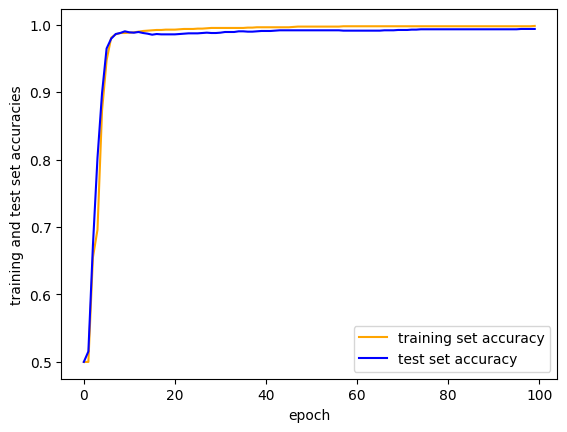

In [ ]:
plt.figure()
plt.plot(accuracy_hist, label="training set accuracy", color = "orange")
plt.plot(accuracy_test_hist, label="test set accuracy", color = "blue")
plt.xlabel("epoch")
plt.ylabel("training and test set accuracies")
plt.legend()
#plt.savefig("XOR_misclassification_errors.pdf")
plt.show()

Obtaining the fc2 output and the classifier

In [ ]:
out_fc2 = 2
#Saving the fc2 layer outputs
outputs_fc2_test_loader = torch.zeros([N, out_fc2])
for index in range(batches):
    patterns = test_data[index*batch_size:(index+1)*batch_size,0:D]
    labels = test_data[index*batch_size:(index+1)*batch_size,D]
    outputs = model_BCE_Logits(patterns)
    outputs_fc2_test_loader[index*batch_size:(index+1)*batch_size,0:out_fc2] =\
        activation["fc2"]
fc2_outputs = outputs_fc2_test_loader.detach().cpu().numpy()

Saving the final layer weights and bias as a linear classifier

In [ ]:
w = np.zeros(3)
weights = model_BCE_Logits.fc3.weight.detach().cpu().numpy()
w[0:2] = weights[0,:]
bias =  model_BCE_Logits.fc3.bias.detach().cpu().numpy()
w[2] = bias[0]
print("weights = ",weights," bias = ",bias)

weights =  [[ 4.310719  -6.0766063]]  bias =  [0.02798142]


The final classifier

In [ ]:
x_c = np.linspace(-1.2,1.2,200)
y_c = -w[0]/w[1]*x_c - w[2]/w[1]

Plots

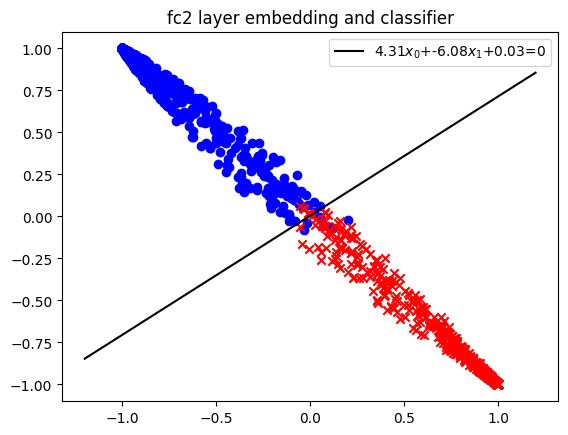

In [ ]:
plt.figure()
plt.scatter(fc2_outputs[N1:N,0],fc2_outputs[N1:N,1], color = "blue", marker = "o")
plt.scatter(fc2_outputs[0:N1,0],fc2_outputs[0:N1,1], color = "red", marker = "x")
plt.plot(x_c, y_c,"k",label="{:.2f}".format(w[0])+"$x_0$+"+"{:.2f}".format(w[1])+"$x_1$"+"+"+"{:.2f}".format(w[2])+"=0")
plt.title("fc2 layer embedding and classifier")
plt.legend()
#Splt.savefig("XOR_fc2_embedding_classifier.pdf")
plt.show()

Print the model

In [ ]:
class XOR_BCESigmoid(nn.Module):
    def __init__(self):
        super().__init__()

        # First fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Tanh()
        )

        # Second fully connected layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=5, out_features=2),
            nn.Tanh()
        )

        # Note linear output layer. Examine the loss function (BCEWithLogitsLoss)
        self.fc3 = nn.Sigmoid()


    def forward(self, x):
        z = self.fc1(x)
        z = self.fc2(z)
        z = self.fc3(z)
        z = torch.squeeze(z)    # Very important. Mismatched dimensions otherwise
        return z

In [ ]:
model_BCE_Sigmoid = XOR_BCESigmoid()
model_BCE_Sigmoid = model_BCE_Sigmoid.float()
model_BCE_Sigmoid.to(device)
model_BCE_Sigmoid.fc2.register_forward_hook(get_activation('fc2'))

In [ ]:
print("----------------------------------------------")
print("Print the model")
print(model_BCE_Logits)
print("----------------------------------------------")
print("Print the model (sigmoid)")
print(model_BCE_Sigmoid)

----------------------------------------------
Print the model
XOR_BCELogits(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=5, out_features=2, bias=True)
    (1): Tanh()
  )
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)
----------------------------------------------
Print the model (sigmoid)
XOR_BCESigmoid(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=5, out_features=2, bias=True)
    (1): Tanh()
  )
  (fc3): Sigmoid()
)
